# Custom object detector

Reference: 06 transfer learning

In [1]:
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
import dataset
import cv2
from utils import set_seed, plot_loss_curves, create_confusion_matrix, save_model

In [3]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


### Load the dataset

In [4]:
class_names = ['Chihuahua', 
           'Golden_retriever', 
           'Welsh_springer_spaniel', 
           'German_shepherd', 
           'Doberman', 
           'Boxer', 
           'Siberian_husky', 
           'Pug', 
           'Pomeranian', 
           'Cardigan']

In [5]:
from pathlib import Path

# Setup path to data folder
data_path = Path("dataset/standford_dogs_mini_10")

# image files paths and annotations
images_path = os.path.join(data_path, "images")
annotations_path = os.path.join(data_path, "yolo", "annotations")

images_path, annotations_path

('dataset/standford_dogs_mini_10/images',
 'dataset/standford_dogs_mini_10/yolo/annotations')

### Create data loaders

In [6]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 1
PIN_MEMORY = True

train_dataloader = dataset.create_dataloader(
    images_path=images_path,
    annotations_path=annotations_path,
    subset="train",
    batch_size=BATCH_SIZE,
    pin_memory=PIN_MEMORY,
    transforms=None,
    num_workers=NUM_WORKERS
)

test_dataloader = dataset.create_dataloader(
    images_path=images_path,
    annotations_path=annotations_path,
    subset="test",
    batch_size=BATCH_SIZE,
    pin_memory=PIN_MEMORY,
    transforms=None,
    num_workers=NUM_WORKERS
)

print(f"train_dataloader: {train_dataloader}")
print(f"test_dataloader: {test_dataloader}")
print(f"class_names: {class_names}")

train_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f8f22d28150>
test_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f8f21867510>
class_names: ['Chihuahua', 'Golden_retriever', 'Welsh_springer_spaniel', 'German_shepherd', 'Doberman', 'Boxer', 'Siberian_husky', 'Pug', 'Pomeranian', 'Cardigan']


### Visualize samples from the dataset

img.shape: torch.Size([3, 224, 224]), label: Welsh_springer_spaniel


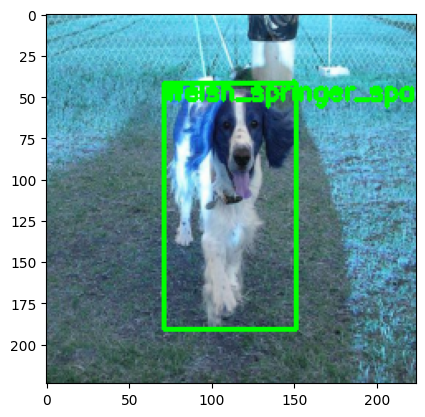

In [7]:
# ImageNet mean and standard deviation
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# get a single image
img_batch, annotation_batch = next(iter(train_dataloader))
img, annotation = img_batch[0], annotation_batch[0]
print(f"img.shape: {img.shape}, label: {class_names[int(annotation[0].numpy())]}")

# visualize
image = img.permute(1, 2, 0).numpy()
image = image * STD + MEAN
image = np.clip(image, 0, 1)
image = (image * 255).astype(np.uint8)

# # show the image
# plt.imshow(image)
# plt.savefig("test.png")

# draw the bounding box
label = annotation[0].numpy()
bbox = annotation[1:].numpy()

# scale the bounding box coordinates
startX = int(bbox[0] * image.shape[1])
startY = int(bbox[1] * image.shape[0])
endX = int(bbox[2] * image.shape[1])
endY = int(bbox[3] * image.shape[0])

# convert PIL image to OpenCV
image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# draw the bounding box
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
cv2.putText(image, str(class_names[int(label)]), (startX, startY + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# save the image
cv2.imwrite("test.png", image)
plt.imshow(image)

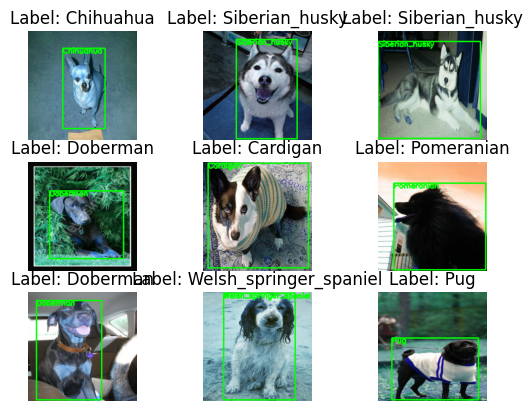

In [8]:
import random

# ImageNet mean and standard deviation
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# # Visualize random 9 images in 3x3 grid
for i in range(9):
    plt.subplot(3, 3, i+1)
    idx = random.randint(0, len(train_dataloader.dataset))
    image, annotation = train_dataloader.dataset[idx][0].permute(1, 2, 0).numpy(), train_dataloader.dataset[idx][1]
    # image
    image = image * STD + MEAN
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    # plt.imshow(image)
    # annotation
    label = annotation[0].numpy()
    bbox = annotation[1:].numpy()

    # scale the bounding box coordinates
    startX = int(bbox[0] * image.shape[1])
    startY = int(bbox[1] * image.shape[0])
    endX = int(bbox[2] * image.shape[1])
    endY = int(bbox[3] * image.shape[0])

    # convert PIL image to OpenCV
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # draw the bounding box
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
    cv2.putText(image, str(class_names[int(label)]), (startX, startY + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.imshow(image)
    plt.title(f"Label: {class_names[int(label)]}")
    plt.axis("off")

### Setup the model

In [9]:
import model

num_classes = 10

# Create the network
weights = torchvision.models.ResNet50_Weights.DEFAULT
basemodel = torchvision.models.resnet50(weights=weights)

model = model.ObjectDetector(basemodel, num_classes)

#### Get the model summary

In [10]:
IMAGE_SIZE = 224
x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE))    

summary(model=model, 
        input_size=(1, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

# NOTE: all layers are trainable

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ObjectDetector (ObjectDetector)               [1, 3, 224, 224]     [1, 10]              --                   True
├─ResNet (backbone)                           [1, 3, 224, 224]     [1, 2048]            --                   True
│    └─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
│    └─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
│    └─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
│    └─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    │    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]    

#### Freeze ResNet50 weights (backbone)

In [11]:
for param in model.backbone.parameters():
    param.requires_grad = False

In [12]:
IMAGE_SIZE = 224
x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE))    

summary(model=model, 
        input_size=(1, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

# NOTE: all ResNet50 layers are not trainable (False) and only 
# classification and bbox regression layers are trainable (True)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ObjectDetector (ObjectDetector)               [1, 3, 224, 224]     [1, 10]              --                   Partial
├─ResNet (backbone)                           [1, 3, 224, 224]     [1, 2048]            --                   False
│    └─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
│    └─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
│    └─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
│    └─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 

### Loss function and optimizer

In [13]:
LR_RATE = 1e-4

# Two loss functions
classLoss_function = torch.nn.CrossEntropyLoss()
bboxLoss_function = torch.nn.MSELoss()
loss_fn = (classLoss_function, bboxLoss_function)

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=LR_RATE)

### Train the model

In [14]:
import engine

set_seed(seed=8)

from timeit import default_timer as timer
start_time = timer()

EPOCHS = 5

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=EPOCHS,
                       device=device)

end_time = timer()
print(f"Time elapsed: {end_time - start_time:.3f} seconds")

# Save model
save_model(model=model, target_dir="models", model_name=f"model_{EPOCHS}.pth")

/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/5 [00:01<?, ?it/s]


ValueError: Expected input batch_size (1) to match target batch_size (0).

In [ ]:
# Evaluation
from utils import plot_loss_curves

plot_loss_curves(results=results)

In [ ]:
from utils import create_confusion_matrix

create_confusion_matrix(model=model,
                        test_loader=test_dataloader,
                        class_names=class_names,
                        device=device)

### Inference on images

In [ ]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms as T
import cv2
import imutils

def pred_and_plot_img(model,
                      img_path,
                      class_names,
                      img_size,
                      transform,
                      device):

    img = Image.open(img_path)

    if transform is not None:
        img_transform = transform
    else:
        img_transform = T.Compose([
            T.ToPILImage(),
            T.ToTensor(),
        ])

    model.to(device)

    model.eval()
    
    with torch.inference_mode():
        img_tensor = img_transform(img).unsqueeze(0)
        img_tensor = img_tensor.to(device)
        prediction = model(img_tensor)

    classPred = prediction[0]
    bboxPred = prediction[1]

    (startX, startY, endX, endY) = bboxPred[0]

    # determine the class label with the largest predicted
	# probability
    classPred = torch.argmax(torch.softmax(classPred[0], dim=1), dim=1).cpu().numpy()
    label = class_names[classPred[0]]

    # resize the original image such that it fits on our screen, and
    # grab its dimensions
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    orig = imutils.resize(orig, width=600)
    (h, w) = orig.shape[:2]
    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)
    # draw the predicted bounding box and class label on the image
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(orig, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
        0.65, (0, 255, 0), 2)
    cv2.rectangle(orig, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    # show the output image 
    # cv2.imshow("Output", orig)
    plt.imshow(orig)
    plt.savefig(f"output_test_pred.jpg")


    # plt.figure()
    # plt.imshow(img)
    # plt.title(f"Prediction: {class_names[pred_class]} | Prob: {pred_probs.max():.3f}")

In [ ]:
import random
# from utils import pred_and_plot_img

test_dir = "/home/kpatel2s/kpatel2s/object_detection/custom_object_detector/dataset/standford_dogs_mini_10/images/n02085620-Chihuahua"

num_imgs = 3
test_img_path_list = list(Path(test_dir).glob("*.jpg"))
test_img_path_sample = random.sample(population=test_img_path_list, k=num_imgs)

for test_img in test_img_path_sample:
    pred_and_plot_img(model=model,
                    img_path=test_img,
                    class_names=class_names,
                    img_size=(224, 224),
                    transform=None,
                    device=device)